In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import compute_calibration_discrete_score, compute_eq_odds_arnold_nvca
from utils.plotting_helpers import safe_save_plt
from utils.plot_fairness import plot_binary_calib_arnold_nvca, plot_eq_odds_arnold_nvca

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa_analysis_all\psa-analysis-public-repo


In [2]:
# read in data 
kentucky_arnold = pd.read_csv("kentucky/data/processed/kentucky_data.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    kentucky_arnold = kentucky_arnold.replace({decoder_name: decoder_dict})

kentucky_arnold.rename(columns=settings['decoders']['label'], inplace=True)
kentucky_arnold.rename(columns=settings['decoders']['arnold_name'], inplace=True)

# compute scaled arnold scores 
for score in ['arnold_nca' , 'arnold_nvca', 'arnold_fta']:
    kentucky_arnold[score] = kentucky_arnold[score + "_raw"]
    kentucky_arnold = kentucky_arnold.replace({score: settings[score + '_scaler'] })
    if score != 'arnold_nvca':
        kentucky_arnold[score] = kentucky_arnold[score].astype(int)
        

kentucky_arnold = kentucky_arnold[['person_id', 'screening_date', 
                                   'arnold_nvca', 
                                    'sex', 'race',
                                    'violent_two_year']]

# wide to long on sensitive attrs
kentucky_long = (pd.melt(kentucky_arnold, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                         .rename({'variable': 'Attribute',
                                  'value': 'Attribute Value'},
                                   axis=1))
kentucky_long = kentucky_long.merge(kentucky_arnold.drop(columns=['sex', 'race']),
                                                    on = ['person_id', 'screening_date'],
                                                    how = 'left')
kentucky_long.head()

,person_id,screening_date,Attribute,Attribute Value,arnold_nvca,violent_two_year
0,5,2015-06-28,sex,male,Yes,0
1,6,2014-06-16,sex,female,No,0
2,8,2016-05-02,sex,male,No,0
3,11,2013-07-07,sex,male,No,0
4,12,2015-07-22,sex,male,No,0


# Arnold NVCA Visualizations

Since the Arnold NVCA score is binary, we generate bar charts rather than line graphs to display calibration, BPC, BNC. 

## Calibration is equivalent to conditional use accuracy equality

$P(Y = 1 | d(x) = 1 , \textit{gender = male}) 
    = P( Y = 1  | d(x) = 1, \textit{gender = female}), \text{(PPV)}$
$P(Y = 1 | d(x) = 0 , \textit{gender = male}) 
    = P( Y = 1  | d(x) = 0, \textit{gender = female}). \text{1 - (NPV)}$
    

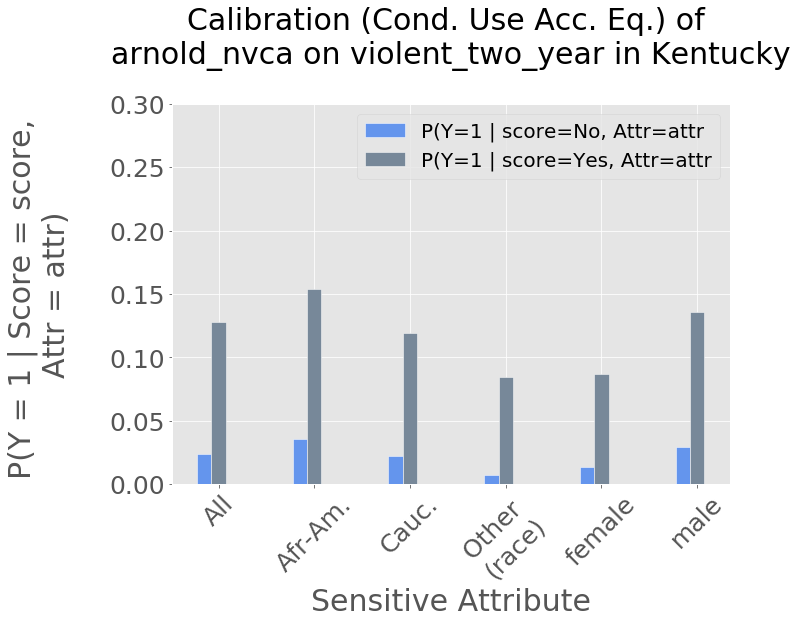

In [3]:
# arnold ncva 
calib, calib_grps = compute_calibration_discrete_score(long_df=kentucky_long, 
                                                        problem_name="violent_two_year", 
                                                        score_name="arnold_nvca")

plot_binary_calib_arnold_nvca(calib=calib, 
                              calib_grps=calib_grps,
                              region_name="Kentucky",
                              save_path='kentucky/logs/fairness_results/calibration_visualizations/arnold/arnold_nvca_calib.pdf')

## BPC/BNC is equivalent to equalized odds

$P(d(x) = 1 | Y = 1, \textit{gender = male}) 
    = P(d(x) = 1 | Y = 1 , \textit{gender = female}), \text{1 - (FNR)}$

$P(d(x) = 1 | Y = 0, \textit{gender = male}) 
    = P(d(x) = 1 | Y = 0 , \textit{gender = female}). \text{(FPR)}$    

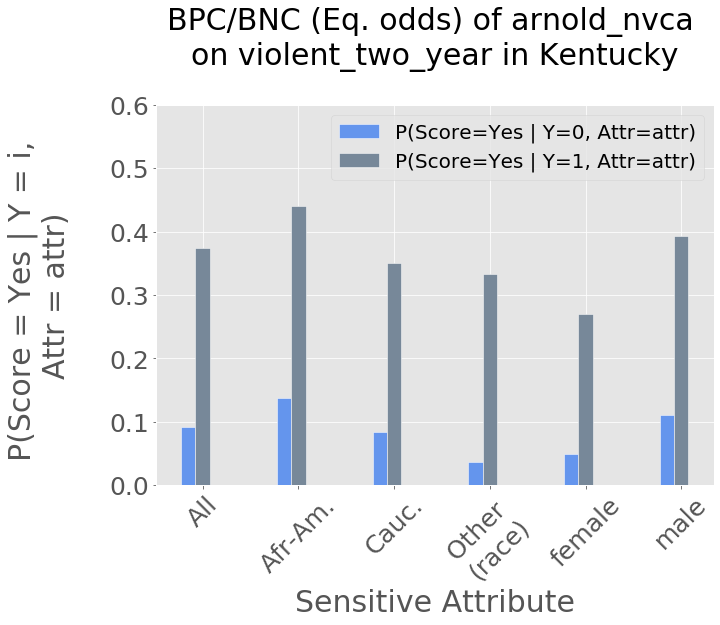

In [4]:
eq_odds, eq_odds_grps = compute_eq_odds_arnold_nvca(long_df=kentucky_long)

plot_eq_odds_arnold_nvca(eq_odds=eq_odds, 
                         eq_odds_grps=eq_odds_grps,
                         region_name="Kentucky",
                         save_path='kentucky/logs/fairness_results/equalized_odds_visualizations/arnold_nvca_eq_odds.pdf')